In [1]:
import pandas as pd
import matplotlib.pyplot as plt
import warnings
idx = pd.IndexSlice
warnings.simplefilter(action='ignore', category=FutureWarning)   
from random import seed
from sklearn.metrics import mean_absolute_error
import statsmodels.api as sm
from statsmodels.tsa.stattools import adfuller
from statsmodels.tsa.statespace.sarimax import SARIMAX
from sklearn.linear_model import LinearRegression
import numpy as np
from sklearn.metrics import mean_squared_error
import math
from sklearn.ensemble import GradientBoostingRegressor
import itertools
from statsmodels.tsa.seasonal import seasonal_decompose
from statsmodels.graphics.tsaplots import plot_acf, plot_pacf
from statsmodels.tsa import stattools
import hashlib # for grading purposes
from sklearn.model_selection import ParameterGrid

from pandas.plotting import lag_plot
from statsmodels.tsa.arima_model import ARIMA
plt.rcParams['figure.figsize'] = (12, 4)

from utils import *

%matplotlib inline

In [12]:
data = pd.read_csv('data/data.csv')

In [3]:
data['date']=pd.to_datetime(data['date'])


In [4]:
data = data.set_index(['date','variable'])


In [5]:
data = data.sort_index()


In [6]:
area1 = data.loc[idx[:,'area_1'],:].reset_index(level='variable',drop=True)
area1 = area1.loc[:area1[area1.value.isnull() == False].iloc[-1].name]
area1.value = area1.value.interpolate()

area2 = data.loc[idx[:,'area_2'],:].reset_index(level='variable',drop=True)
area2 = area2.loc[:area2[area2.value.isnull() == False].iloc[-1].name]
area2.value = area2.value.interpolate()

area3 = data.loc[idx[:,'area_3'],:].reset_index(level='variable',drop=True)
area3 = area3.loc[:area3[area3.value.isnull() == False].iloc[-1].name]
area3.value = area3.value.interpolate()

# area1.head(5)

In [7]:
area1_logged = area1['value'].map(np.log)
area1_logged_diffed = area1_logged.diff()

In [8]:
exo.head()

NameError: name 'exo' is not defined

In [9]:
exo = area1_logged.copy()
exo = exo.reset_index()
exo['day_of_week'] = exo['date'].dt.dayofweek
exo['month'] = exo['date'].dt.month
exo['sin_weekday'] = np.sin(2*np.pi*exo['date'].dt.dayofweek/7)
exo['cos_weekday'] = np.cos(2*np.pi*exo['date'].dt.dayofweek/7)
exo['sin_month'] = np.sin(2*np.pi*exo['date'].dt.month/12)
exo['cos_month'] = np.cos(2*np.pi*exo['date'].dt.month/12)
exo = exo.set_index('date')
exo = exo.drop('value',axis=1)

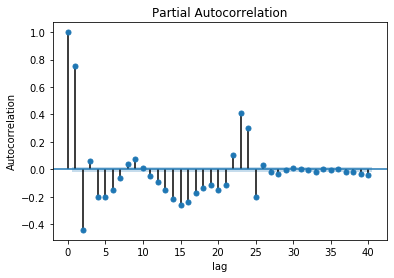

In [10]:
plot_pacf(area1_logged_diffed.dropna(), alpha=.05, lags=40)  
plt.xlabel('lag')
plt.ylabel('Autocorrelation')
plt.show()

In [ ]:
#data.loc[idx[:,'area_2'],:].unstack(1).value.plot()

In [ ]:
#data.loc[idx[:,'area_1'],:].unstack(1).value.plot()

In [ ]:
p = q = [1]
d = [0]
P = D = Q = range(0, 2)   #  <--- all of the paramters between 0 and 2 

S = [24] # <-- let's pretend we have a couple of hypothesis 

In [ ]:
params_combinations = list(itertools.product(p, d, q, P, D, Q, S))

In [ ]:
inputs = [[x[0], x[1], x[2], x[3], x[4], x[5], x[6]] for x in params_combinations]

In [ ]:
def get_aic(series_, params):
    # extract the params 
    p = params[0] 
    d = params[1] 
    q = params[2] 
    P = params[3]
    D = params[4] 
    Q = params[5]
    S = params[6]
    
    # fit a model with those params 
    model = SARIMAX(series_,order=(p, d, q), seasonal_order=(P, D, Q, S),
                                     enforce_stationarity=False,
                                     enforce_invertibility=False)
    
    # fit the model
    results = model.fit(maxiter=200)
    predictions_best_model = results.get_prediction()
    mep = mean_absolute_percentage_error(series_[1:],np.exp(predictions_best_model.predicted_mean)[1:])
    
    # return the aic 
    return mep

In [ ]:
%%time 

aic_scores = {}
params_index = {}

for i in range(len(inputs)):
    try: 
        param_set = inputs[i]
        aic = get_aic(area1_logged, param_set) 
        aic_scores[i] = aic
        params_index[i] = param_set
    
    # this will fail sometimes with impossible parameter combinations. 
    # ... and I'm too lazy to remember what they are. 
    except Exception as e: 
        continue

In [ ]:
temp = pd.DataFrame(params_index).T
temp.columns = ['p', 'd', 'q', 'P', 'D', 'Q', 'S']
temp['aic'] = pd.Series(aic_scores)
temp.sort_values('aic').head()

In [ ]:
exo

In [33]:
best_model = SARIMAX(area1_logged,
                                      order=(1, 0, 1),
                                      seasonal_order=(0, 1, 0, 24),
                                      exog=exo['day_of_week'])

results = best_model.fit()
predictions_best_model = results.get_prediction()

/home/fc/anaconda3/envs/hckt03/lib/python3.7/site-packages/statsmodels/tsa/base/tsa_model.py:165: ValueWarning: No frequency information was provided, so inferred frequency H will be used.
  % freq, ValueWarning)


In [ ]:
area1.tail()

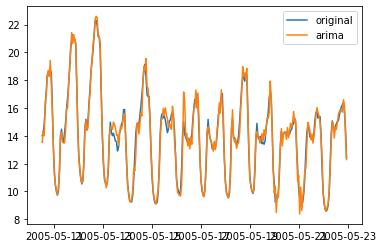

In [34]:
plt.plot(area1[-300:], label='original')
plt.plot(np.exp(predictions_best_model.predicted_mean[-300:]), label='arima')
plt.legend()
plt.show();

In [35]:
train_1 = area1_logged[:-168]
test_1 = area1_logged[-168:]

In [ ]:
mae_model = sm.tsa.statespace.SARIMAX(train_1,
                                      order=(1, 0, 1),
                                      seasonal_order=(0, 1, 0, 24),
                                      exog=exo[:-168])

results = mae_model.fit()
predictions_mae_model = results.get_forecast(steps=168)

/home/fc/anaconda3/envs/hckt03/lib/python3.7/site-packages/statsmodels/tsa/base/tsa_model.py:165: ValueWarning: No frequency information was provided, so inferred frequency H will be used.
  % freq, ValueWarning)


In [ ]:
plt.plot(area2[-300:],label='original')
plt.plot(np.exp(predictions_mae_model.predicted_mean), label='arima')
plt.show();

In [ ]:
mean_absolute_percentage_error(area1[-168:],np.exp(predictions_mae_model.predicted_mean))

In [11]:
mae_model = sm.tsa.statespace.SARIMAX(area1_logged,
                                      order=(1, 0, 1),
                                      seasonal_order=(0, 1,0, 24),
                                      exog=exo)

results = mae_model.fit()
predictions_mae_model = results.get_forecast(steps=168)

/home/fc/anaconda3/envs/hckt03/lib/python3.7/site-packages/statsmodels/tsa/base/tsa_model.py:165: ValueWarning: No frequency information was provided, so inferred frequency H will be used.
  % freq, ValueWarning)
/home/fc/anaconda3/envs/hckt03/lib/python3.7/site-packages/statsmodels/base/model.py:512: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  "Check mle_retvals", ConvergenceWarning)


ValueError: Out-of-sample forecasting in a model with a regression component requires additional exogenous values via the `exog` argument.

In [ ]:
area1_pred = np.exp(predictions_mae_model.predicted_mean)

In [ ]:
area1_pred_day = pd.read_csv('daily_area1_pred.csv')
area1_pred_day['Unnamed: 0'] = pd.to_datetime(area1_pred_day['Unnamed: 0'])
area1_pred_day = area1_pred_day.set_index('Unnamed: 0')

In [ ]:
area1_pred_day.head()

In [ ]:
area1_pred_day = area1_pred_day.resample('H').mean().interpolate()
area1_pred_day = area1_pred_day.reset_index()
area1_pred_day.columns = ['date','value']
area1_pred_day =  area1_pred_day.set_index('date')

In [ ]:
#area1_pred_day #+ 
pd.DataFrame(area1_pred,columns=['value'])

In [ ]:
media_dh.head(5)

In [ ]:
media_dh = (area1_pred_day['value'] + area1_pred)/2
pd.DataFrame(media_dh,columns=['value']).plot()
plt.plot(area1[-300:],label='original')
plt.show()

In [ ]:
plt.scatter(area1_pred_day.index,area1_pred_day.values)
plt.plot(area1[:],label='original')
#area1_pred.plot()
plt.show()

In [ ]:
plt.plot(area1[-300:].reset_index(drop=True)['value'],label='original')
pd.read_csv('linear_model_data1.csv')['value'].plot()
plt.show()

In [ ]:
plt.plot(area1[-300:].reset_index(drop=True)['value'],label='original')

area1_pred.reset_index(drop=True).plot()
plt.show()

In [ ]:
area2_pred = np.exp(predictions_mae_model.predicted_mean)


In [ ]:
area2_pred.plot()

In [ ]:
area3_pred = np.exp(predictions_mae_model.predicted_mean)


In [ ]:
area3_pred.plot()

In [ ]:
generate_submission_file(area1_pred,area2_pred,area3_pred)

In [ ]:
predictions_area_1 = area1_pred
predictions_area_2 = area2_pred
predicitons_area_3 = area3_pred
#test_1 = pd.DataFrame(predictions_area_1)


In [ ]:
test_1 = pd.DataFrame(predictions_area_1)
test_2 = pd.DataFrame(predictions_area_2)
test_3 = pd.DataFrame(predicitons_area_3)
test = pd.concat([test_1,test_2,test_3], axis=1)


In [ ]:
test.columns = ['area_1','area_2','area_3']
test.index.name = 'date'
test = test.reset_index().melt(id_vars='date',value_vars=['area_1','area_2','area_3']).set_index('date')
test = test.dropna()
test = test.drop('variable',axis=1)
test.to_csv('submission.csv')

In [ ]:
test.plot()